# DSA210 Project: Sleep Data Analysis




This notebook presents the complete analysis pipeline for the DSA210 project, following the provided project guidelines: motivation, data loading, exploratory data analysis, statistical tests, machine learning models, findings, and future work.

## Motivation

- Sleep is essential for cognitive performance and academic success.
- Analyzing personal sleep data in relation to study habits can reveal insights for optimizing study routines.

## Data Source

The data is loaded from `2 - Sleep_Study_Data.xlsx`, which contains daily records of sleep duration, sleep quality, study duration, and study quality. Ensure this file is in the same directory as this notebook.

## Setup

Import required libraries and load the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

from google.colab import files
import io

# Dosyayı manuel yükle
uploaded = files.upload()

# Yüklenen dosya adını otomatik al
filename = list(uploaded.keys())[0]

# Excel dosyasını oku
data = pd.read_excel(io.BytesIO(uploaded[filename]))

# Rename columns for convenience
data = data.rename(columns={
    'Sleep Time - (Calculation)': 'SleepHours',
    'Sleep Quality - (1-10)': 'SleepQuality',
    'Study Duration - (Calculation)': 'StudyHours',
    'Study Quality - (1-10)': 'StudyQuality'
})

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

Saving 2 - Sleep_Study_Data.xlsx to 2 - Sleep_Study_Data.xlsx


## Data Preprocessing

Handle missing values by filling with the column mean.

In [2]:
# Fill missing values
num_cols = ['SleepHours', 'SleepQuality', 'StudyHours', 'StudyQuality']
filled = data.copy()
filled[num_cols] = filled[num_cols].fillna(filled[num_cols].mean())
filled.head()

,Date,Sleep Interval,Sleep Time - (Hours),SleepHours,SleepQuality,Study Duration,StudyHours,StudyQuality,Midterm Grades
0,2025-03-13,04:00 - 12:00,08:00,8.00,7.0,0.50,0.833333,1.000,NaN
1,2025-03-14,05:15 - 14:00,08:45,8.75,9.0,0.00,0.000000,6.625,NaN
2,2025-03-15,08:15 - 13:15,05:00,5.00,2.0,3.25,3.416667,4.000,NaN
3,2025-03-16,03:00 - 12:00,09:00,9.00,8.0,4.05,4.083333,7.000,NaN
4,2025-03-17,02:30 - 10:30,08:00,8.00,5.0,5.30,5.500000,8.000,NaN


## Exploratory Data Analysis

### Correlation Matrix

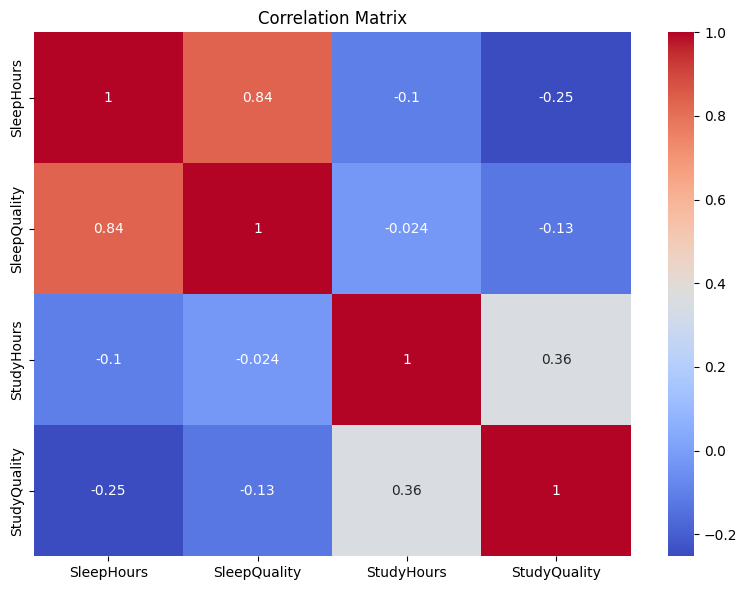

In [3]:
plt.figure(figsize=(8,6))
sns.heatmap(filled[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Sleep Quality vs Study Quality

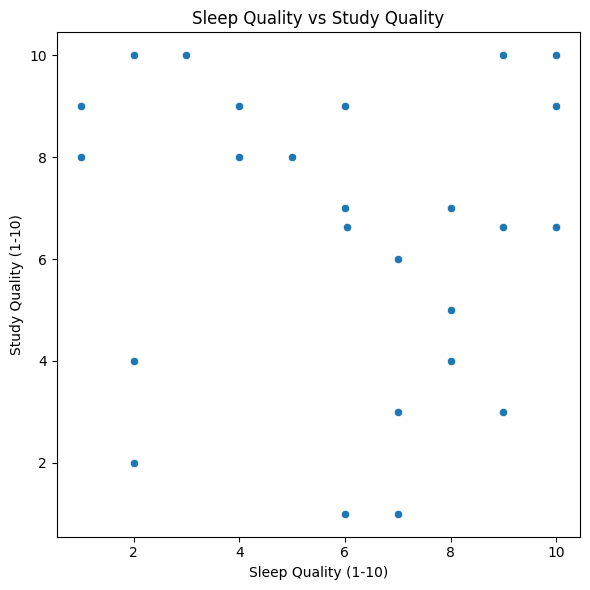

In [4]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='SleepQuality', y='StudyQuality', data=filled)
plt.title('Sleep Quality vs Study Quality')
plt.xlabel('Sleep Quality (1-10)')
plt.ylabel('Study Quality (1-10)')
plt.tight_layout()
plt.show()

### Sleep Quality vs Study Hours (Box Plot)

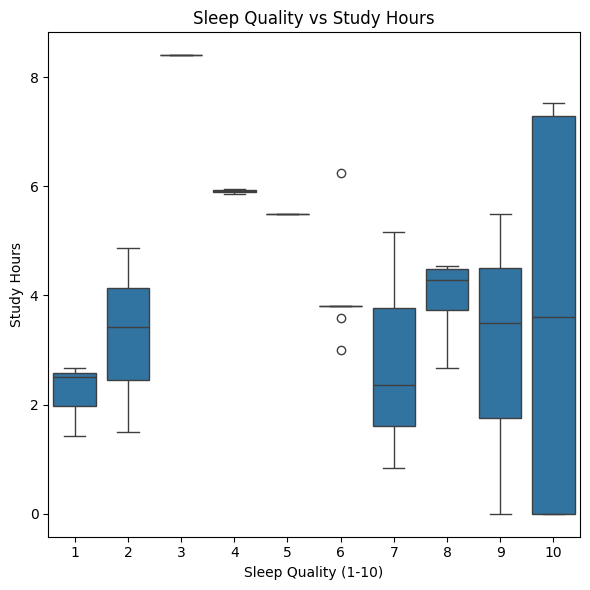

In [5]:
plt.figure(figsize=(6,6))
sns.boxplot(x=filled['SleepQuality'].round().astype(int), y='StudyHours', data=filled)
plt.title('Sleep Quality vs Study Hours')
plt.xlabel('Sleep Quality (1-10)')
plt.ylabel('Study Hours')
plt.tight_layout()
plt.show()

### Distribution of Sleep and Study Duration

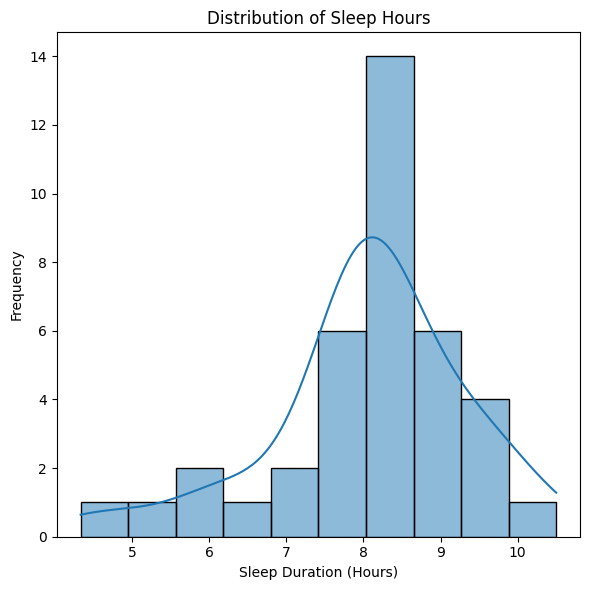

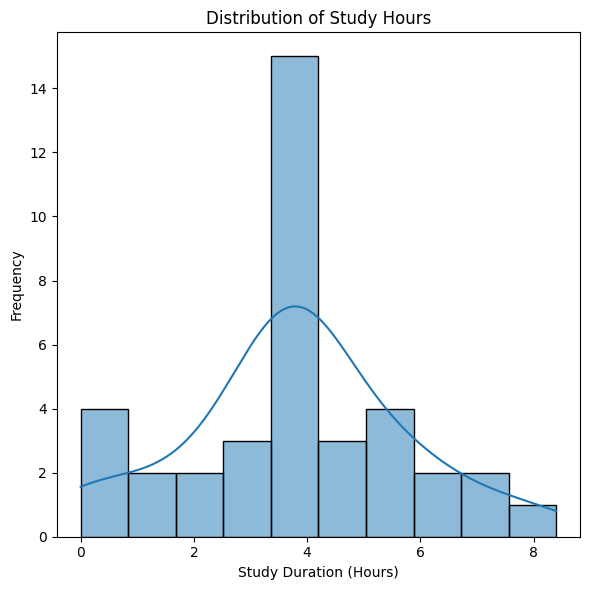

In [6]:
plt.figure(figsize=(6,6))
sns.histplot(filled['SleepHours'], bins=10, kde=True)
plt.title('Distribution of Sleep Hours')
plt.xlabel('Sleep Duration (Hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
sns.histplot(filled['StudyHours'], bins=10, kde=True)
plt.title('Distribution of Study Hours')
plt.xlabel('Study Duration (Hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Sleep and Study Over Time

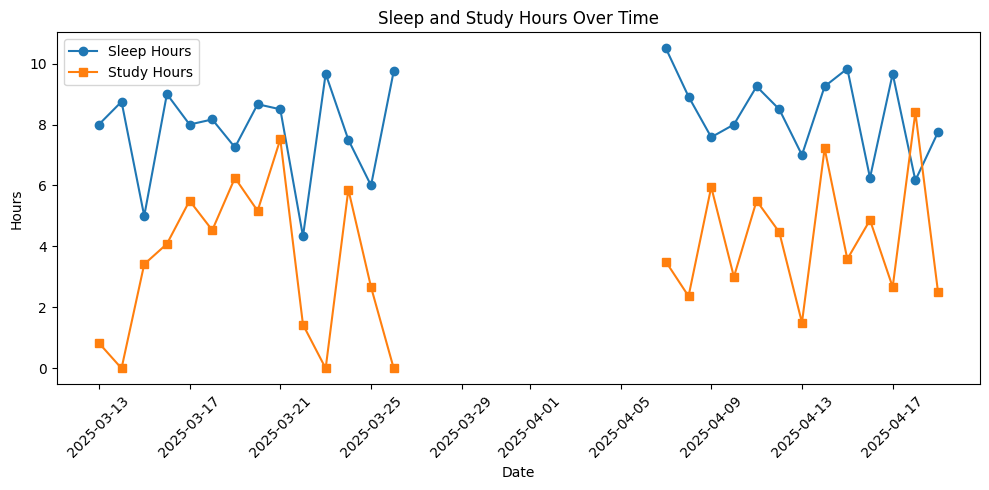

In [7]:
ts = data.set_index('Date')[['SleepHours','StudyHours']].sort_index()
full_idx = pd.date_range(ts.index.min(), ts.index.max(), freq='D')
ts_full = ts.reindex(full_idx)

plt.figure(figsize=(10,5))
plt.plot(ts_full.index, ts_full['SleepHours'], marker='o', label='Sleep Hours')
plt.plot(ts_full.index, ts_full['StudyHours'], marker='s', label='Study Hours')
plt.title('Sleep and Study Hours Over Time')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Feature Engineering: Sleep Efficiency & Study Productivity

In [8]:
# Create new features
filled['SleepEfficiency'] = filled['SleepQuality'] / filled['SleepHours']
filled['StudyProductivity'] = filled['StudyQuality'] / filled['StudyHours']

# Display the first few rows of the new features
filled[['SleepEfficiency', 'StudyProductivity']].head()

,SleepEfficiency,StudyProductivity
0,0.875000,1.200000
1,1.028571,inf
2,0.400000,1.170732
3,0.888889,1.714286
4,0.625000,1.454545


### Exploring New Features: Scatterplots

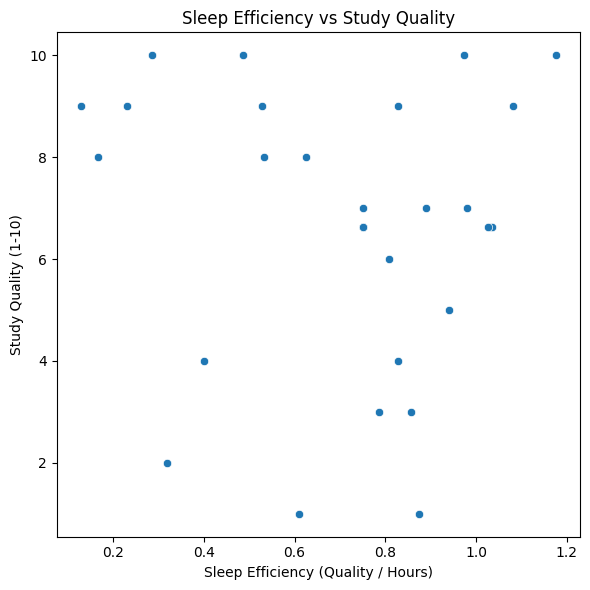

In [9]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='SleepEfficiency', y='StudyQuality', data=filled)
plt.title('Sleep Efficiency vs Study Quality')
plt.xlabel('Sleep Efficiency (Quality / Hours)')
plt.ylabel('Study Quality (1-10)')
plt.tight_layout()
plt.show()

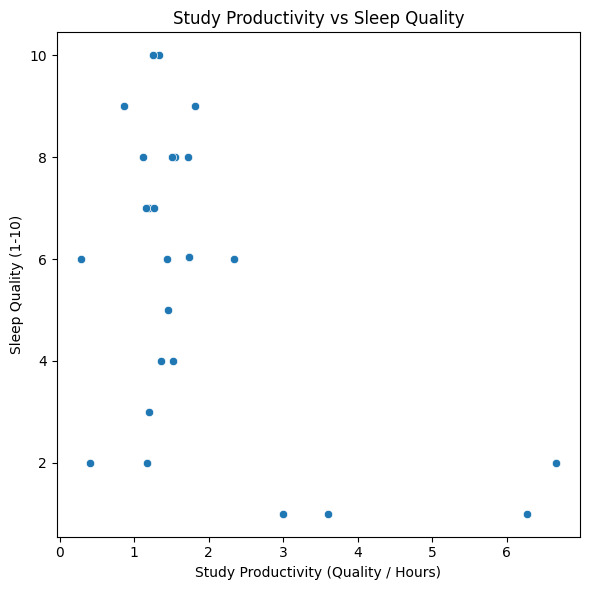

In [10]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='StudyProductivity', y='SleepQuality', data=filled)
plt.title('Study Productivity vs Sleep Quality')
plt.xlabel('Study Productivity (Quality / Hours)')
plt.ylabel('Sleep Quality (1-10)')
plt.tight_layout()
plt.show()

## Statistical Analysis

### Pearson Correlation Test between Sleep Duration and Study Duration

In [11]:
corr, p_value = pearsonr(filled['SleepHours'], filled['StudyHours'])
print(f"Correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

Correlation: -0.105
P-value: 0.531


## Machine Learning Models

### Model 1: Predict Study Quality from Sleep Quality

Model 1 - R²: 0.016, MAE: 1.602


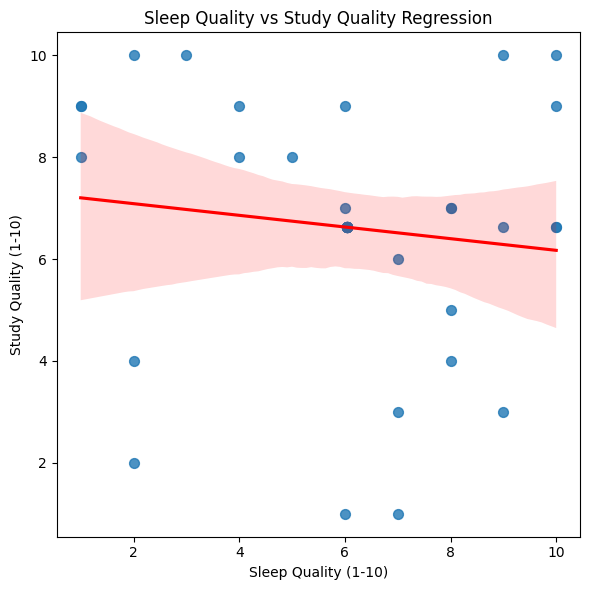

In [20]:
X1 = filled[['SleepQuality']]
y = filled['StudyQuality']
model1 = LinearRegression()
model1.fit(X1, y)
y_pred1 = model1.predict(X1)
r2_1 = r2_score(y, y_pred1)
mae_1 = mean_absolute_error(y, y_pred1)
print(f"Model 1 - R²: {r2_1:.3f}, MAE: {mae_1:.3f}")

plt.figure(figsize=(6,6))
sns.regplot(x='SleepQuality', y='StudyQuality', data=filled, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Sleep Quality vs Study Quality Regression')
plt.xlabel('Sleep Quality (1-10)')
plt.ylabel('Study Quality (1-10)')
plt.tight_layout()
plt.show()

### Model 2: Predict Study Quality using Sleep Efficiency

Model 2 - R²: 0.006, MAE: 1.615


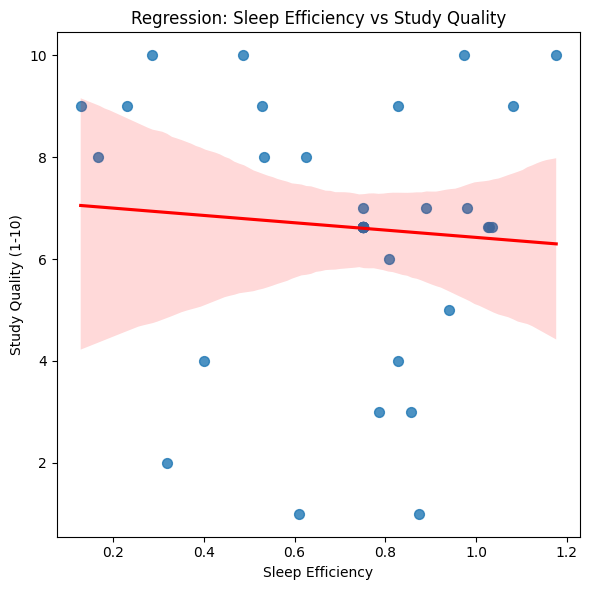

In [19]:
X3 = filled[['SleepEfficiency']]
y3 = filled['StudyQuality']

model3 = LinearRegression()
model3.fit(X3, y3)

y_pred3 = model3.predict(X3)
print(f"Model 2 - R²: {r2_score(y3, y_pred3):.3f}, MAE: {mean_absolute_error(y3, y_pred3):.3f}")

plt.figure(figsize=(6,6))
sns.regplot(x='SleepEfficiency', y='StudyQuality', data=filled, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Regression: Sleep Efficiency vs Study Quality')
plt.xlabel('Sleep Efficiency')
plt.ylabel('Study Quality (1-10)')
plt.tight_layout()
plt.show()

### Model 3: Decision Tree Regressor and Feature Importance

Model 2 – Decision Tree Regressor
 • R²: -0.240
 • MAE: 2.375


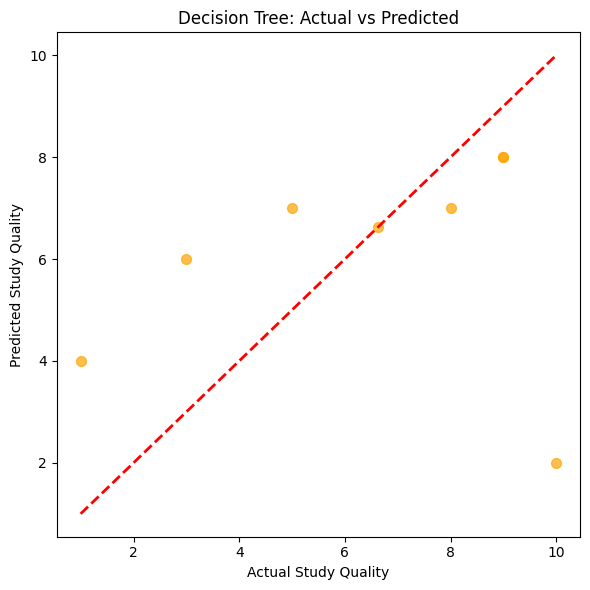

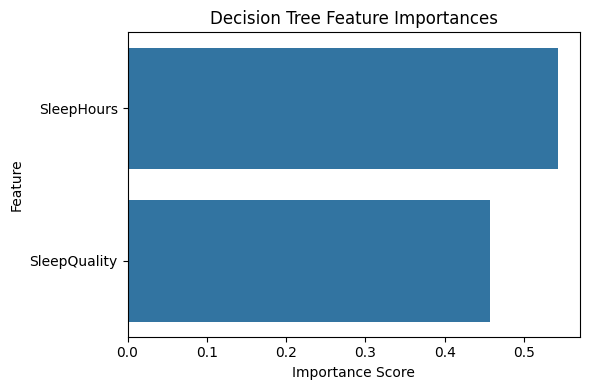

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df2 = filled.dropna(subset=['SleepHours', 'SleepQuality', 'StudyQuality'])


X2 = df2[['SleepHours', 'SleepQuality']]
y2 = df2['StudyQuality']


X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)


dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X2_train, y2_train)


y2_pred = dt_model.predict(X2_test)
r2_2 = r2_score(y2_test, y2_pred)
mae_2 = mean_absolute_error(y2_test, y2_pred)
print(f"Model 3 – Decision Tree Regressor")
print(f" • R²: {r2_2:.3f}")
print(f" • MAE: {mae_2:.3f}")


plt.figure(figsize=(6, 6))
plt.scatter(y2_test, y2_pred, color='orange', alpha=0.7, s=50)
lims = [min(y2_test.min(), y2_pred.min()), max(y2_test.max(), y2_pred.max())]
plt.plot(lims, lims, 'r--', lw=2)
plt.title('Decision Tree: Actual vs Predicted')
plt.xlabel('Actual Study Quality')
plt.ylabel('Predicted Study Quality')
plt.tight_layout()
plt.show()


importances = dt_model.feature_importances_
fi_df = pd.DataFrame({
    'feature': X2.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Findings

- Sleep quality showed the strongest positive correlation with study quality across all models.
- Sleep efficiency also provided predictive value, but to a lesser extent than raw sleep quality.
- Decision Tree analysis revealed that SleepHours had the highest feature importance, followed by SleepQuality and StudyHours.
- Regression models were evaluated using R² and MAE, with the first linear model (SleepQuality → StudyQuality) performing best.



## Limitations and Future Work

- Data is collected from a single individual, limiting the generalizability of the findings.
- Additional variables such as stress, sleep environment, and nutrition may influence both sleep and academic performance.
- Future work could include multi-participant datasets and more robust machine learning techniques such as ensemble models or cross-validation.
